In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Here we incorporate GaBP into the framework of geometric multigrid.

In [2]:
def full_weight_restriction(u):
    K = int(np.sqrt(len(u)))
    M = int((K-1)/2)
    v = np.zeros((M, M))
    w = u.reshape((K, K))
    v += w[1::2, 1::2]/4 + (w[::2, 1::2][:-1, :] + w[2::2, 1::2])/8
    v += (w[1::2, ::2][:, :-1] + w[1::2, 2::2])/8
    v += (w[::2, ::2][:-1, :-1] + w[2::2, 2::2] + w[::2, 2::2][:-1, :] + w[2::2, ::2][:, :-1])/16
    v = v.reshape(-1,)
    return v

In [3]:
H = []
E = []
for J in [3, 4, 5, 6, 7]:
    N = 2**J - 1
    h = 1/(N+1)
    x = np.linspace(h, 1-h, N)
    X, Y = np.meshgrid(x, x, indexing='ij')

    u =  (np.sin(X*np.pi)*np.sin(Y*np.pi)).reshape(-1,)
    vv = u.reshape((N, N))[1::2, 1::2]
    vv = vv.reshape(-1,)
    v = full_weight_restriction(u)
    e = np.linalg.norm(vv - v, ord=np.inf)
    H.append(h)
    E.append(e)

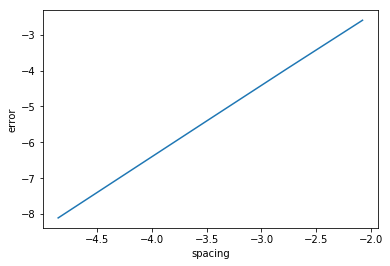

In [4]:
plt.plot(np.log(H), np.log(E))
plt.xlabel('spacing')
plt.ylabel('error');

In [5]:
def full_weight_prolongation(u):
    K = int(np.sqrt(len(u)))
    v = np.zeros((2*K+1, 2*K+1))
    v[1::2, 1::2] = u.reshape((K, K))
    v[1::2, ::2][:, :-1] += v[1::2, 1::2]/2
    v[1::2, 2::2] += v[1::2, 1::2]/2
    v[::2, :][:-1, :] += v[1::2, :]/2
    v[2::2, :] += v[1::2, :]/2
    v = v.reshape(-1,)
    return v

In [6]:
H = []
E = []
for J in [3, 4, 5, 6, 7]:
    N = 2**J - 1
    h = 1/(N+1)
    H.append(h)
    
    x = np.linspace(h, 1-h, N)
    X, Y = np.meshgrid(x, x, indexing='ij')
    u = (np.sin(X*np.pi)*np.sin(2*Y*np.pi)).reshape(-1,)
    v = full_weight_prolongation(u)
    
    N = 2**(J+1) - 1
    h = 1/(N+1)
    
    x = np.linspace(h, 1-h, N)
    X, Y = np.meshgrid(x, x, indexing='ij')
    vv = (np.sin(X*np.pi)*np.sin(2*Y*np.pi)).reshape(-1,)

    e = np.linalg.norm(vv - v, ord=np.inf)
    E.append(e)

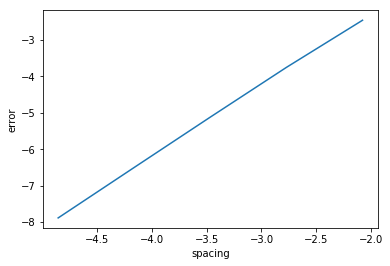

In [7]:
plt.plot(np.log(H), np.log(E))
plt.xlabel('spacing')
plt.ylabel('error');

In [8]:
from scipy.linalg import solve_triangular

def GS_smoother(A, b, x_0, N):
    L_A = np.tril(A)
    r_A = A - L_A
    x = np.copy(x_0)
    for _ in range(N):
        x = solve_triangular(L_A, b - r_A @ x, lower=True)
    return x

In [9]:
def GaBP_smoother(A, d, x_0, N, type='Sequential'):
    v_out = []
    v_in = []
    for i in range(len(A[0, :])):
        v_out.append(np.where(A[i] != 0)[0])
        v_in.append(np.where(A[:, i] != 0)[0])

        v_out[i] = v_out[i][v_out[i] != i]
        v_in[i] = v_in[i][v_in[i] != i]

    L, L_new, mu, mu_new = np.zeros_like(A), np.zeros_like(A), np.zeros_like(A), np.zeros_like(A)
    x = np.zeros_like(d)
    b = d - A@x_0

    for _ in range(N):
        for j in range(len(A[0,:])):
            m = b[j] + np.sum(L[v_out[j], j]*mu[v_out[j], j])
            Sigma = A[j, j] + np.sum(A[v_out[j], j]*L[v_out[j], j])
            x[j] = m/Sigma
            if type == 'Sequential':
                mu[j, v_in[j]] = m - L[v_in[j], j]*mu[v_in[j], j]
                L[j, v_in[j]] = -A[v_in[j], j]/(Sigma - L[v_in[j], j]*A[v_in[j], j])
            if type == 'Parallel':
                mu_new[j, v_in[j]] = m - L[v_in[j], j]*mu[v_in[j], j]
                L_new[j, v_in[j]] = -A[v_in[j], j]/(Sigma - L[v_in[j], j]*A[v_in[j], j])
        if type == 'Parallel':
            mu, L = np.copy(mu_new), np.copy(L_new)
    return x_0 + x

In [10]:
def exact_marginalization(A, b):
    inverse = np.linalg.inv(A)
    variances = np.diag(inverse)
    means = (inverse @ b)
    return variances, means

def stripes_GaBP_smoother(A, d, x_0, N_it):
    b = d - A@x_0
    N = len(b)
    me, var = np.zeros_like(b), np.zeros_like(b)
    M = int(np.sqrt(N))
    horizontal_regions = np.arange(N).reshape((M,-1))
    m_h = np.zeros((M, M, 2))# [from which horizontal, to which vertical, mean/variance]
    vertical_regions = np.arange(N).reshape((M,-1)).T
    m_v = np.zeros((M, M, 2))# [from which vertical, to which horizontal, mean/variance]

    A_horizontal = np.zeros((M, M, M))
    b_horizontal = np.zeros((M, M))
    A_vertical = np.zeros((M, M, M))
    b_vertical = np.zeros((M, M))

    for i in range(M):
        x, y = np.meshgrid(horizontal_regions[i], horizontal_regions[i], indexing='ij')
        w, z = np.meshgrid(vertical_regions[i], vertical_regions[i], indexing='ij')
        A_horizontal[i] = A[x, y]
        A_vertical[i] = A[w, z]
        b_horizontal[i] = b[horizontal_regions[i]]
        b_vertical[i] = b[vertical_regions[i]]

    me = np.zeros_like(b)
    for _ in range(N_it):

        # horizontal update
        for i in range(M):
            delta_A = np.diag(m_v[:, i, 1])
            delta_b = m_v[:, i, 0]*m_v[:, i, 1]
            variances, means = exact_marginalization(A_horizontal[i]+delta_A, b_horizontal[i]+delta_b)
            m_h[i, :, 1] = 1/variances - (np.diag(A_horizontal[i]) + m_v[:, i, 1])
            m_h[i, :, 0] = (means/variances - (b_horizontal[i] + delta_b))/m_h[i, :, 1]

        # vertical update
        for i in range(M):
            delta_A = np.diag(m_h[:, i, 1])
            delta_b = m_h[:, i, 0]*m_h[:, i, 1]
            variances, means = exact_marginalization(A_vertical[i]+delta_A, b_vertical[i]+delta_b)
            m_v[i, :, 1] = 1/variances - (np.diag(A_vertical[i]) + m_h[:, i, 1])
            m_v[i, :, 0] = (means/variances - (b_vertical[i] + delta_b))/m_v[i, :, 1]

            ##
            me[vertical_regions[i]] = means
            var[vertical_regions[i]] = variances
            ##

    return x_0 + me

\begin{equation}
\begin{split}
    Ax^{n} &= b \\
    A \left(\overline{x} - x^{n}\right) &= b - A x^{n} = d^{n}\\
    e^{n} &= A^{-1} d^{n}\\
    \overline{x} &= x^{n} + e^{n}
\end{split}
\end{equation}

In [11]:
def multigrid_V_sweep(A, b, x_0, smoother, N_pre, N_post):
    if len(A) == 1:
        return x_0 + np.linalg.inv(A[0]) @ b
    # pre smoothing
    x_0 = smoother(A[0], b, x_0, N_pre)
    # restriction
    y = full_weight_restriction(b - A[0]@x_0)
    # coarse solution
    e = multigrid_V_sweep(A[1:], y, 0*y, smoother, N_pre, N_post)
    # prolongation
    x_0 += full_weight_prolongation(e)
    # post smoothing
    x_0 = smoother(A[0], b, x_0, N_post)
    return x_0

In [12]:
import equations
from scipy.sparse import coo_matrix
import bvp

In [13]:
def construct_multigrid_hierarchy(equation, J, l):
    a, alpha, b, beta, q, f_rhs, up, left, down, right, exact = equation(1, 1)
    AA = []
    
    n = 2**J - 1
    h = 1/(n+1)
    x, y = np.linspace(h, 1-h, n), np.linspace(h, 1-h, n)
    X, Y = np.meshgrid(x, y, indexing='ij')
    rhs = bvp.mod_rhs(a, alpha, b, beta, q, f_rhs, up, left, down, right, 1, 1, n, n)

    for j in range(J, J-l, -1):
        n = 2**j - 1
        row, col, values = bvp.d2A(a, alpha, b, beta, q, 1, 1, n, n)
        A = coo_matrix((values, (row, col))).toarray()
        AA.append(A)
    return AA, rhs

Below you can see results for Laplace equation.

In [14]:
A, rhs = construct_multigrid_hierarchy(equations.laplacian, 6, 3)

In [15]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 3, 3)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)

86.4312259429
2.59245487447
0.0995458802915
0.00448375668898
0.000208690920459
9.8830711579e-06
4.71470826824e-07


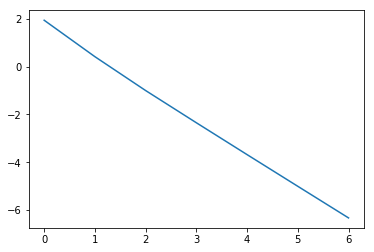

In [16]:
plt.plot(np.log10(E))

In [17]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)

1236.06659832
167.385720991
38.7159531013
8.00803375525
1.5321986013
0.337057026365
0.0742990552114
0.0152356199318
0.0034095677704
0.000866622005793
0.000207140009922
4.08839209562e-05
9.84666360893e-06
2.25869380976e-06
4.72828903142e-07


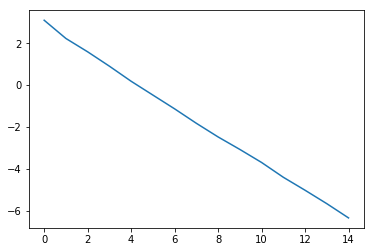

In [18]:
plt.plot(np.log10(E))

In the case of large anisotropy, GaBP is more robust.

In [19]:
equation = lambda L_x, L_y: equations.epsilon_laplacian(L_x, L_y, 0.001)
A, rhs = construct_multigrid_hierarchy(equation, 6, 3)

In [20]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-5
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 3, 3)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)

133.560327517
55.8494867964
36.2018324787
27.1860462473
21.9332045607
18.3222979048
15.7629250577
13.8091498144
12.1987018111
10.9108005485
9.82724167187
8.9020245458
8.08493654701
7.39152218788
6.76820371372
6.21390539715
5.72347115114
5.27712765066
4.87040524257
4.49925974631
4.16401073666
3.85920737891
3.57882275039
3.32067580601
3.08279811516
2.86341549833
2.66092912001
2.47389729351
2.30168361481
2.14324647333
1.9964152549
1.86028105807
1.73401253802
1.61684868484
1.50809227263
1.4071039442
1.31329688418
1.22613202862
1.14511375885
1.06978602977
0.999728886167
0.934555325009
0.873908465634
0.817458994176
0.764902852112
0.715959142487
0.670645782584
0.628436201394
0.589083079507
0.552384686389
0.518154046983
0.486217814395
0.456415234326
0.428597193115
0.402625342086
0.378371291521
0.355715868293
0.334548431704
0.314766242619
0.296273881428
0.278982710782
0.262889790154
0.247900900156
0.233868308302
0.220727203226
0.208417310335
0.196882567071
0.186070821988
0.175933555818
0.166425

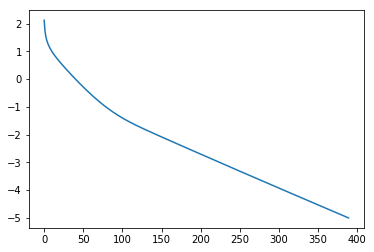

In [21]:
plt.plot(np.log10(E))

In [22]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-5
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)

3698.18205218
3382.73734381
3093.94471262
2829.31791242
2586.75680523
2364.34884353
2160.35524574
1973.18763314
1801.38649929
1643.6117216
1498.63395543
1365.32282393
1242.6384402
1129.62371166
1025.39669254
929.143533536
840.112304989
757.607178985
680.982895726
609.639772586
543.019041653
480.598438882
421.888130765
366.426898398
313.77850657
263.528299068
215.279970675
168.652492068
125.565639468
84.2690968653
43.6768109121
0.451203505087
0.32534374727
0.244916923735
0.184444510485
0.138483452848
0.102934322971
0.0753804000069
0.054158301733
0.0380293913804
0.0259325386887
0.0170470790472
0.0106584586301
0.00620376796633
0.00352675779277
0.0027316433725
0.0024723490209
0.00217584984011
0.00185908506683
0.00150606220132
0.00116470115836
0.000857356261804
0.000619921435828
0.000472330017146
0.000339957338838
0.000228303893891
0.000175592143933
0.000135143333864
0.000101654614049
9.00584781576e-05
7.93121084826e-05
7.19273912182e-05
5.92918736402e-05
4.53381790066e-05
3.15106531161e-05

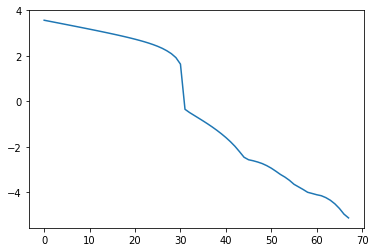

In [23]:
plt.plot(np.log10(E))

In [24]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-5
E = []
smoother = stripes_GaBP_smoother
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)

0.0672385031289
0.000180957758499
9.27539383966e-07


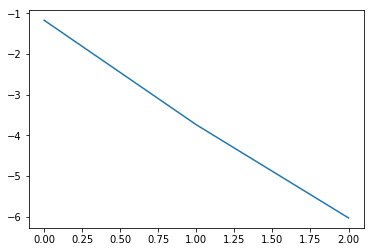

In [25]:
plt.plot(np.log10(E))

Convergence rate does not depend on the magnitude of the anisotropy parameter.

In [26]:
EE = []
eps = []
for epsilon in np.logspace(-6, -3, 4):
    eps.append(epsilon)
    equation = lambda L_x, L_y: equations.epsilon_laplacian(L_x, L_y, epsilon)
    A, rhs = construct_multigrid_hierarchy(equation, 6, 3)

    x_0 = np.zeros_like(rhs)
    error = 1
    tol = 1e-5
    E = []
    smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
    while error > tol:
        x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 2, 2)
        error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
        E.append(error)
    EE.append(E)

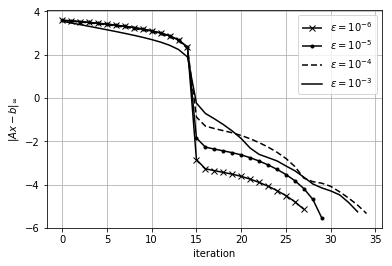

In [27]:
plt.plot(np.log10(EE[0]), 'x', dashes=[2, 0, 2, 0], color='black', label='$\\epsilon = 10^{-6}$')
plt.plot(np.log10(EE[1]), '.', dashes=[2, 0, 2, 0], color='black', label='$\\epsilon = 10^{-5}$')
plt.plot(np.log10(EE[2]), dashes=[4, 2, 4, 2], color='black', label='$\\epsilon = 10^{-4}$')
plt.plot(np.log10(EE[3]), color='black', label='$\\epsilon = 10^{-3}$')
plt.xlabel('iteration')
plt.ylabel('$\\left\|Ax - b\\right\|_{\\infty}$')
plt.grid()
plt.legend();
#plt.savefig('anisotropic_equation_2_sweeps.eps', format='eps')

In [28]:
EE = []
eps = []
for epsilon in np.logspace(-6, -3, 4):
    eps.append(epsilon)
    equation = lambda L_x, L_y: equations.epsilon_laplacian(L_x, L_y, epsilon)
    A, rhs = construct_multigrid_hierarchy(equation, 6, 3)

    x_0 = np.zeros_like(rhs)
    error = 1
    tol = 1e-5
    E = []
    smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
    while error > tol:
        x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 3, 3)
        error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
        E.append(error)
    EE.append(E)

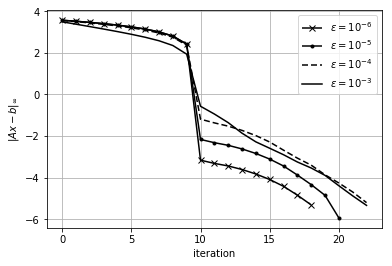

In [29]:
plt.plot(np.log10(EE[0]), 'x', dashes=[2, 0, 2, 0], color='black', label='$\\epsilon = 10^{-6}$')
plt.plot(np.log10(EE[1]), '.', dashes=[2, 0, 2, 0], color='black', label='$\\epsilon = 10^{-5}$')
plt.plot(np.log10(EE[2]), dashes=[4, 2, 4, 2], color='black', label='$\\epsilon = 10^{-4}$')
plt.plot(np.log10(EE[3]), color='black', label='$\\epsilon = 10^{-3}$')
plt.xlabel('iteration')
plt.ylabel('$\\left\|Ax - b\\right\|_{\\infty}$')
plt.grid()
plt.legend();
#plt.savefig('anisotropic_equation_3_sweeps.eps', format='eps')

More examples for different equations.

In [30]:
A, rhs = construct_multigrid_hierarchy(equations.equation_5, 6, 3)

626.912422284
216.436928622
122.534729324
67.4394480188
35.8258426753
18.94635078
10.0954942261
5.41237093926
2.90561564897
1.561932621
0.840650450964
0.452948559513
0.244296560079
0.131880564833
0.0712531462741
0.038526190715
0.0208453562928
0.0112859778465
0.00611397416836
0.00331392487445
0.00179712558023
0.000975022574522
0.000529220533309
0.000287363177478
0.000156093859943
8.48183317714e-05
4.61033787644e-05
2.50671928654e-05
1.36332710383e-05
7.41665465398e-06
4.0357345199e-06
2.19652977762e-06
1.19576273505e-06
6.51091824011e-07


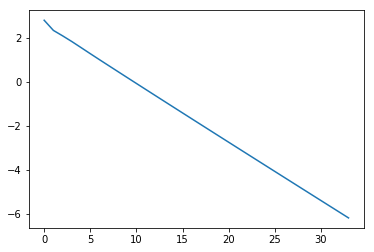

In [31]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

4426.63863104
2555.52515497
1116.23971929
354.032648639
83.8391238253
13.0954174948
2.16899383053
0.891318538152
0.378496871586
0.137146403741
0.0433186168216
0.0116524527242
0.00352972586316
0.00172378554243
0.000655808509519
0.000245982002866
0.000127560232839
4.48880036554e-05
1.47609709149e-05
4.32786837745e-06
1.75797780022e-06
7.88449544209e-07


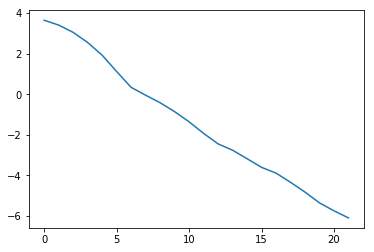

In [32]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

In [33]:
A, rhs = construct_multigrid_hierarchy(equations.equation_2, 6, 3)

2778.9991815
366.077487337
58.1162300561
8.93938185657
1.33556917277
0.195093703665
0.0290313189753
0.00474265340199
0.000767187072142
0.000122052103052
1.90778823708e-05
2.94248002319e-06
4.44880242867e-07


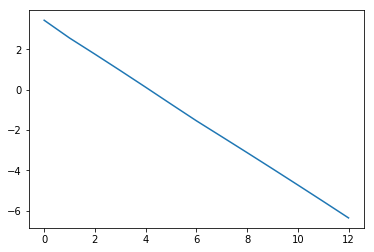

In [34]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

8806.97442185
1834.58647599
432.770265812
122.937035327
38.1422957448
10.1649161741
2.49546408215
0.661411580194
0.164772621917
0.0407460432821
0.00997938816442
0.00266291888695
0.000803732392569
0.000248718554424
7.56556242045e-05
2.0371741698e-05
5.06018567847e-06
1.34600069235e-06
3.26857367838e-07


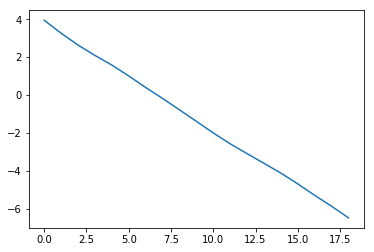

In [35]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

In [36]:
A, rhs = construct_multigrid_hierarchy(equations.equation_6, 6, 6)

1720.74632578
258.299520518
117.208221658
52.246927371
22.4991028526
9.4303352594
3.89460435223
1.58422977697
0.642198871926
0.258509543774
0.103601523638
0.0414016856939
0.0165139769642
0.00658885462155
0.00262573452449
0.00104542922338
0.000415956117763
0.000165418847359
6.57600168097e-05
2.6134775112e-05
1.03845078456e-05
4.12559450069e-06
1.63884317317e-06
6.5095730406e-07


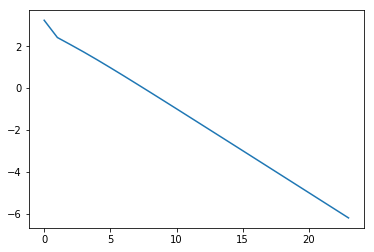

In [37]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

4957.03822641
1205.35665767
517.217201182
215.855676683
87.3722810419
34.2004579571
13.0188173968
4.80277121554
1.75429091028
0.638426726174
0.257025550771
0.0996387079048
0.0368870794274
0.0131387900587
0.00446298687356
0.00145353351051
0.00044972038161
0.000132656331573
3.69198164663e-05
9.70697396951e-06
2.5051706416e-06
7.64745891502e-07


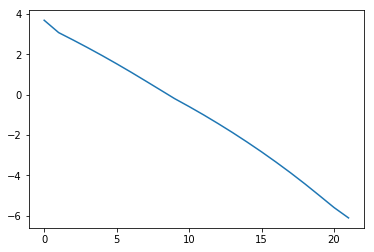

In [38]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

In [39]:
import sympy as sp

def equation_7(L_x, L_y):
    x, y = sp.symbols('x, y', real=True)
    a = sp.exp(-x*y) + 3
    b = sp.exp(-2*x+2*y)
    alpha = sp.cos(sp.pi*(x + y/2)) + 4
    beta = sp.exp(2*x - 2*y)
    q = sp.exp(-3*x-4*y)
    exact = sp.cos(sp.pi*x)*sp.cos(sp.pi*y)
    return equations.construct_equation(a, b, alpha, beta, q, exact, x, y, L_x, L_y)

In [40]:
A, rhs = construct_multigrid_hierarchy(equation_7, 6, 6)

5500.16516789
1605.24792082
432.756232431
106.795032698
24.9765965469
5.3650062038
1.03830069746
0.18165621846
0.0291615103955
0.0040704353185
0.000496103707704
6.02352999906e-05
6.56223481599e-06
5.67994248968e-07


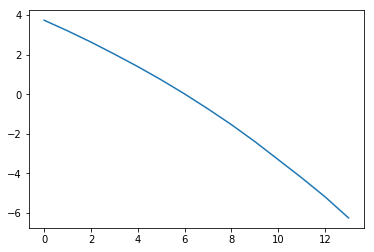

In [41]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

7365.63982484
4069.39668154
2221.83238719
1191.48682337
626.106797865
322.075214408
161.99157579
80.2734773429
39.4389639813
18.9816278569
8.94050348486
4.1161726295
1.8504444074
0.811145747028
0.346287152715
0.14371771573
0.0579060543268
0.0226022146173
0.00853299251686
0.00336280728254
0.00134505450035
0.000521143569358
0.000193714956367
6.95722026194e-05
2.39113649059e-05
7.91552201918e-06
2.4989267331e-06
7.5683601608e-07


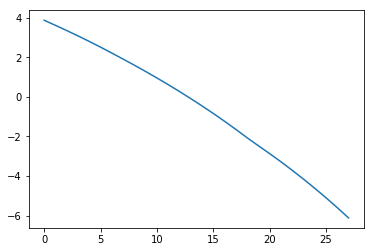

In [42]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

ellipticity is almost lost

In [43]:
import sympy as sp

def equation_8(L_x, L_y):
    x, y = sp.symbols('x, y', real=True)
    a = sp.exp(-x*y)
    b = sp.exp(-2*x+2*y)
    alpha = sp.cos(sp.pi*(x + y/2))
    beta = sp.exp(2*x - 2*y)
    q = 4*sp.exp(-3*x-4*y)
    exact = sp.cos(sp.pi*x)*sp.cos(sp.pi*y)
    return equations.construct_equation(a, b, alpha, beta, q, exact, x, y, L_x, L_y)

In [44]:
A, rhs = construct_multigrid_hierarchy(equation_8, 6, 6)

2030.16484198
408.745424631
99.0936147294
24.0708640787
5.97210999747
4.02544265758
2.74856693994
1.89041685707
1.30576840892
0.904233556809
0.627091779345
0.435223211117
0.302150260789
0.209765122922
0.145599251042
0.101029409679
0.0700756271938
0.0485844860525
0.0336689126955
0.0233214850116
0.0161464495716
0.0111735643498
0.00772861374141
0.00534328864821
0.00369245459776
0.00255049017894
0.00176090767243
0.00121522407996
0.000838272642135
0.000577996922651
0.000398363069756
0.000274440228416
0.000188987610521
0.000130088008767
8.95078158223e-05
6.15609917745e-05
4.2322594048e-05
2.90845203139e-05
1.99790695419e-05
1.37186973674e-05
9.41619443751e-06
6.46045307207e-06
4.4307373841e-06
3.03748426944e-06
2.08150802194e-06
1.4258260066e-06
9.76293698329e-07


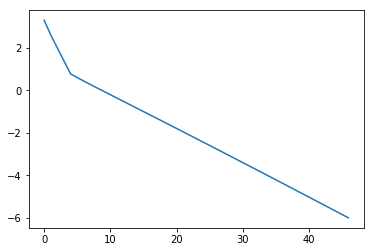

In [45]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

6946.8389912
1873.23083453
508.719471032
132.228751287
32.6864293744
8.35472332728
2.72997743485
1.97624699837
1.43252001873
1.04406119413
0.765282511039
0.559970335936
0.409339211396
0.299065220961
0.218435515992
0.159522085246
0.116492261474
0.0850696168554
0.0621249484075
0.0453710911415
0.0331373829449
0.0242038939568
0.0176799665023
0.0129153811386
0.00943545045175
0.00689362195226
0.00503687708715
0.00368047507527
0.00268951873113
0.00196549949578
0.00143647629466
0.00104990655291
0.000767412695495
0.000560961379961
0.000410073870626
0.00029978913426
0.000219176431528
0.000160249074725
0.000117171081911
8.56777596709e-05
6.2652455199e-05
4.58173462903e-05
3.35075901603e-05
2.45062847171e-05
1.79238932105e-05
1.31101396619e-05
9.58963482844e-06
7.01481076248e-06
5.13155646331e-06
3.75475726599e-06
2.74835590375e-06
2.01176251124e-06
1.47262587546e-06
1.07800885729e-06
7.89156068493e-07


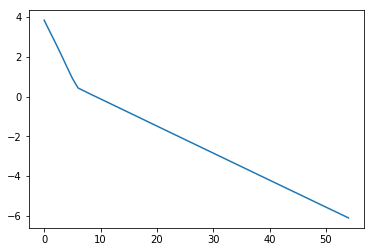

In [46]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

large advection

In [47]:
import sympy as sp

def equation_9(L_x, L_y):
    x, y = sp.symbols('x, y', real=True)
    a = sp.exp(-x*y)
    b = sp.exp(-2*x+2*y)
    alpha = sp.cos(sp.pi*(x + y/2)) + 90
    beta = sp.exp(2*x - 2*y)
    q = 0
    exact = sp.cos(sp.pi*x)*sp.cos(sp.pi*y)
    return equations.construct_equation(a, b, alpha, beta, q, exact, x, y, L_x, L_y)

In [48]:
A, rhs = construct_multigrid_hierarchy(equation_9, 6, 3)

In [49]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E_1 = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E_1.append(error)

2669.85983223
1282.96214845
974.8856581
922.787228105
917.371346605
738.697994098
509.648821101
345.95224309
257.690466675
195.682636303
147.22782718
111.781278106
101.544890707
68.9199957316
55.0465916242
44.4325158501
37.4774409323
34.1525298195
38.3741514981
30.8512238065
25.7100363695
23.9157504331
22.306302416
20.8287089683
19.4459234153
18.146479458
16.9564365104
15.8177510068
14.7560766265
13.7740806925
12.8596143982
12.0103722654
11.2193883984
10.4782708258
9.78290506372
9.13467310272
8.53037220144
7.96640597441
7.44059579728
6.94938173776
6.48993250545
6.06058837177
5.65981122213
5.28571202908
4.93654179509
4.61055738171
4.30599896657
4.02143882926
3.75565744465
3.50747115796
3.27573958329
3.05936616367
2.85729038537
2.66853466477
2.49222738497
2.3275651586
2.17379144744
2.03019131899
1.89608550234
1.77083604755
1.65385393077
1.54459574347
1.44255548513
1.34725921363
1.25826144203
1.17514378179
1.09751573081
1.02501425533
0.957301489819
0.894062109109
0.83500111319
0.779842250

6511.85637428
2103.19775945
1233.29606057
685.686565251
403.680159427
281.845947789
177.478027582
131.183536829
88.2114724063
61.0737243189
44.1968011973
32.0877681789
22.6285869087
15.1413117047
11.4107517379
9.09134550367
6.75985148304
5.93845387467
6.05160944148
5.54829449772
4.66655096027
3.87233662299
3.26848015404
2.68705879749
2.15880668437
1.66786829446
1.22116179111
0.87021244722
0.595012758818
0.414201830119
0.312673980452
0.259261511691
0.248327667734
0.23454062736
0.209508467501
0.17929988496
0.152770495901
0.129701476579
0.105472242347
0.0839199571841
0.0646159343129
0.0474425112028
0.033489922629
0.0230922601655
0.0153087474154
0.0115599052078
0.00938295470885
0.00900318064769
0.00858193649713
0.00773999179962
0.00661494004401
0.00560663216711
0.00475395500743
0.00386017705138
0.00306918518446
0.00236091324054
0.00172872959352
0.00121778142478
0.00083382898025
0.000565316636283
0.00042630967431
0.00034934685052
0.000336257979235
0.000320347144616
0.00028704810854
0.000244

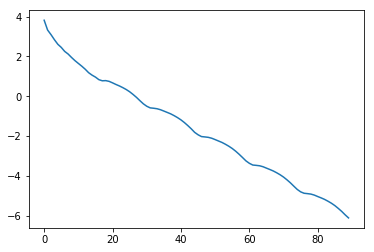

In [50]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

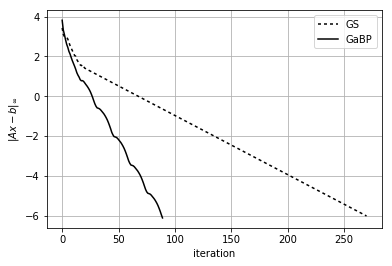

In [51]:
plt.plot(np.log10(E_1), dashes=[2, 2, 2, 2], color='black', label='GS')
plt.plot(np.log10(E), color='black', label='GaBP')
plt.xlabel('iteration')
plt.ylabel('$\\left\|Ax - b\\right\|_{\\infty}$')
plt.legend()
plt.grid()
plt.savefig('large_advection_sweeps.eps', format='eps')

____
____
____

In [52]:
def sigma_laplacian(L_x, L_y, epsilon):
    x, y = sp.symbols('x, y', real=True)
    a = 1
    b = 1
    alpha = 0
    beta = 0
    q = 2*sp.sin(sp.pi*y/epsilon)
    exact = sp.cos(sp.pi*x)*sp.cos(sp.pi*y)
    return equations.construct_equation(a, b, alpha, beta, q, exact, x, y, L_x, L_y)

In [53]:
eq = lambda L_x, L_y: sigma_laplacian(L_x, L_y, 0.01)
A, rhs = construct_multigrid_hierarchy(eq, 6, 3)

270.227323811
15.5848898697
1.40512669915
0.371855287301
0.105174855119
0.0277776573313
0.00783319127237
0.00218558673959
0.000582311610239
0.000164794362117
4.34125565363e-05
1.23525013898e-05
3.25216804242e-06
9.20443394392e-07


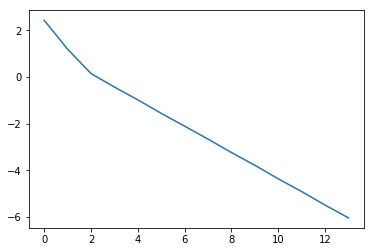

In [54]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

928.493636928
110.070892984
22.0600825165
3.84383912163
0.948179021691
0.183879106235
0.0485104625117
0.0100498564779
0.00195854541027
0.000631613899401
0.000217773179012
4.84426144727e-05
1.42366509124e-05
4.27099494971e-06
1.1535810458e-06
3.79559483843e-07


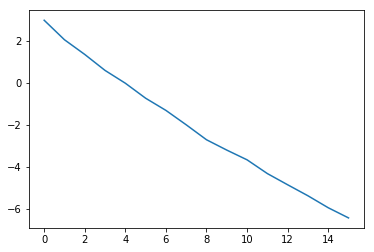

In [55]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

large anisotropy

In [56]:
def equation_8(L_x, L_y):
    x, y = sp.symbols('x, y', real=True)
    a = sp.exp(-6*(x+y-1)**2)*1000 + 1
    b = sp.exp(-6*(x-y)**2)*1000 + 1
    alpha = 0
    beta = 0
    q = 0
    exact = sp.cos(sp.pi*x)*sp.cos(sp.pi*y)
    return equations.construct_equation(a, b, alpha, beta, q, exact, x, y, L_x, L_y)

In [57]:
A, rhs = construct_multigrid_hierarchy(equation_8, 6, 6)

241281.253675
104601.471098
72354.2631449
53011.6680478
39994.6852053
30076.2211799
23340.1895353
18024.1887983
13842.2534885
10623.4899177
8137.43111821
6217.26898219
4741.81302675
3612.20966401
2749.58979958
2091.99449891
1591.2708282
1210.27496355
920.503810476
700.163180584
532.629308537
405.242861627
308.373633962
234.700439727
178.659448986
136.02299603
103.578733591
78.8855900183
60.0883179247
45.7766435925
34.8783193176
26.5779243359
20.2552117185
15.4382895353
11.7680599155
8.97120270049
6.83964538909
5.21495807925
3.97648884644
3.0323407418
2.31250812448
1.76365437786
1.3451375911
1.02598536815
0.782591639174
0.596962833399
0.455382176762
0.347392237833
0.265019811777
0.20218531703
0.154252747627
0.117686673155
0.0897908090556
0.0685087257007
0.0522719357105
0.0398840523267
0.0304324804747
0.0232210691029
0.0177187613153
0.0135204229446
0.0103169773647
0.00787262673839
0.00600746562122
0.00458423755481
0.0034982181096
0.00266950074001
0.00203712013899
0.00155455441563
0.00118

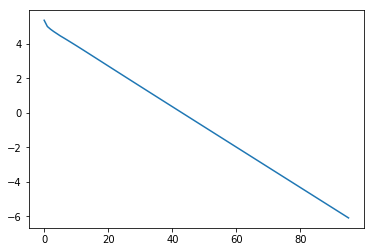

In [58]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 2, 2)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

2970948.66314
2183979.69366
1526808.25555
1007139.59473
621761.302714
355864.630127
186782.862735
88780.0581617
37650.6500791
13991.5390925
4450.84688777
1174.36825172
245.53892234
37.9623134853
8.31442469096
1.89122026655
0.545291816954
0.214120454349
0.0883067318546
0.0305660624072
0.0105899230502
0.00458370001706
0.00165293821919
0.000552178935322
0.000247772976763
9.76676428763e-05
3.81594163628e-05
1.69419608937e-05
6.93105812388e-06
2.43211889028e-06
9.69700522546e-07


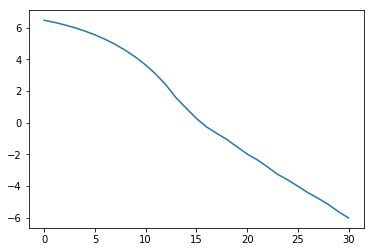

In [59]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    print(error)
    E.append(error)
plt.plot(np.log10(E))

In [60]:
def equation_9(L_x, L_y):
    x, y = sp.symbols('x, y', real=True)
    a = (1.0001-sp.cos(30*sp.pi*(x*y)))
    b = (1.0001+sp.cos(30*sp.pi*(x*y)))
    alpha = 0
    beta = 0
    q = 0
    exact = sp.cos(sp.pi*x)*sp.cos(sp.pi*y)
    return equations.construct_equation(a, b, alpha, beta, q, exact, x, y, L_x, L_y)

In [61]:
A, rhs = construct_multigrid_hierarchy(equation_9, 6, 6)

In [62]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E_1 = []
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, GS_smoother, 3, 3)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    E_1.append(error)

In [63]:
x_0 = np.zeros_like(rhs)
error = 1
tol = 1e-6
E_2 = []
smoother = lambda A, d, x_0, N: GaBP_smoother(A, d, x_0, N, type='Sequential')
while error > tol:
    x_0 = multigrid_V_sweep(A, rhs, x_0, smoother, 1, 1)
    error = np.linalg.norm(A[0]@x_0 - rhs, ord=np.inf)
    E_2.append(error)

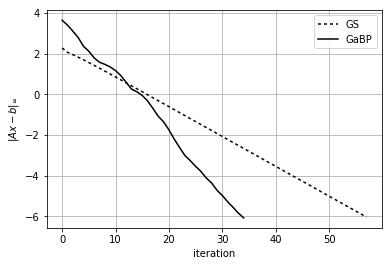

In [64]:
plt.plot(np.log10(E_1), dashes=[2, 2, 2, 2], color='black', label='GS')
plt.plot(np.log10(E_2), color='black', label='GaBP')
plt.xlabel('iteration')
plt.ylabel('$\\left\|Ax - b\\right\|_{\\infty}$')
plt.legend()
plt.grid()
plt.savefig('anisotropic_equation_cos_sweeps.eps', format='eps')